In [2]:
from transformers import LlavaNextProcessor, LlavaNextForConditionalGeneration, LlavaProcessor, LlavaForConditionalGeneration
import torch
from PIL import Image
import requests
import time
import numpy as np
from helper import *

/home/hasan/.local/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
model_id = "llava-hf/llava-v1.6-mistral-7b-hf"

quantization = True

processor = LlavaNextProcessor.from_pretrained(model_id)
model = LlavaNextForConditionalGeneration.from_pretrained(
    model_id, 
    torch_dtype=torch.float16, 
    low_cpu_mem_usage=True, 
    load_in_8bit=quantization,
    attn_implementation="eager",
)
if quantization is False: # hot fix for: .to` is not supported for `4-bit` or `8-bit` bitsandbytes models. 
    # Please use the model as it is, since the model has already been set to the correct devices and casted to the correct `dtype`.
    model = model.to("cuda:0")

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.
The `load_in_4bit` and `load_in_8bit` arguments are deprecated and will be removed in the future versions. Please, pass a `BitsAndBytesConfig` object in `quantization_config` argument instead.
Loading checkpoint shards: 100%|██████████| 4/4 [00:20<00:00,  5.21s/it]


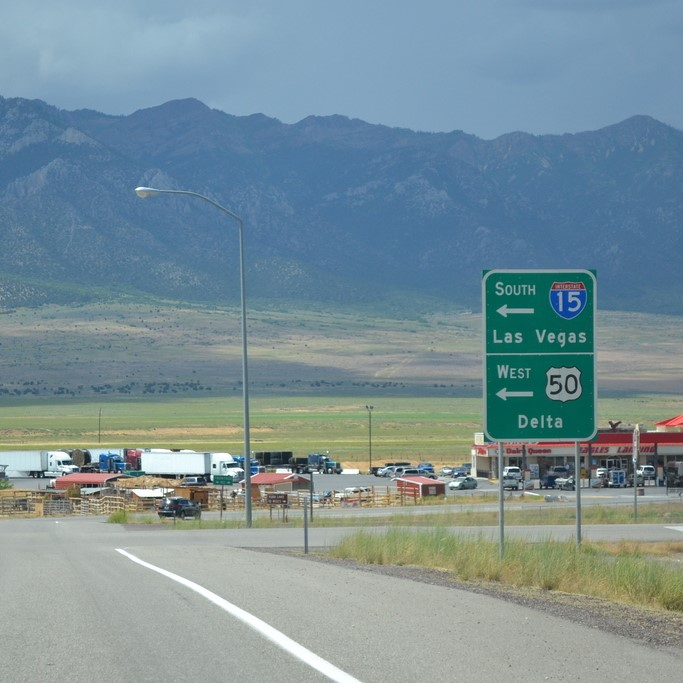

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


num_tokens_generated: 43


In [4]:
model.config.fast_vlm_config = {
    "spatial_budget": 0,
    "alpha_vision_token_budget": 0.1,
    "beta_sub_images_budget": 0.5,
    "clip_attn_layer": 0,
}

image = Image.open("textvqa.jpg")
# image = get_random_image(h=400, w=400)
image.show()
prompt = "[INST] <image>\nExplain the image in details. Tell about every aspects of the image.\n[/INST]"
inputs = processor(prompt, image, return_tensors="pt").to("cuda:0")

with torch.inference_mode():
    output = model.generate(
        **inputs,
        do_sample=False,
        max_new_tokens=15,
        use_cache=True,
        return_dict_in_generate=True,
        )
    
# length of newly generated tokens
num_tokens_generated = len(output['sequences'][0])
print(f"num_tokens_generated: {num_tokens_generated}")
output_text = processor.decode(output['sequences'][0], skip_special_tokens=False)
inputs = processor(output_text, image, return_tensors='pt').to(0, torch.float16)
with torch.inference_mode():
    output = model(**inputs, output_attentions=True, return_dict=True)

In [5]:
def plot_attentin_map_in_nxn_grid(attention_scores,topk=115):
    """
    Plot the attention map in a n x n grid
    assume num_token_patches is a perfect square
    attention_scores: torch tensor [num_token_patches]
    """
    num_tokens = attention_scores.shape[0]
    num_token_grid = int(np.sqrt(num_tokens))

    # we want to assign 1 to num_tokens score based on the attention_scores tensor
    rank = torch.argsort(attention_scores, descending=True)
    attention_scores_rank = torch.zeros_like(attention_scores)
    
    for i in range(topk):
        attention_scores_rank[rank[i]] = i+1

    # plot the attention map in a n x n grid
    attention_scores_rank = attention_scores_rank.reshape((num_token_grid, num_token_grid)).cpu().detach().numpy()
    
    # Plotting the attention heatmap
    plt.figure(figsize=(5, 5))
    plt.imshow(attention_scores_rank, cmap='Blues', interpolation='nearest') 
    
    # remove labels
    plt.xticks([])
    plt.yticks([])
    plt.show()

In [12]:
def plot_attentin_map_in_nxn_grid(attention_scores):
    """
    Plot the attention map in a n x n grid
    assume num_token_patches is a perfect square
    attention_scores: torch tensor [num_token_patches]
    """
    num_tokens = attention_scores.shape[0]
    num_token_grid = int(np.sqrt(num_tokens))

    # plot the attention map in a n x n grid
    attention_scores = attention_scores.reshape((num_token_grid, num_token_grid))
    
    # Plotting the attention heatmap
    plt.figure(figsize=(5, 5))
    plt.imshow(attention_scores, cmap='Blues') 
    
    # remove labels
    plt.xticks([])
    plt.yticks([])
    plt.show()

In [13]:
model.kvto_mask[0].shape

torch.Size([5, 576])

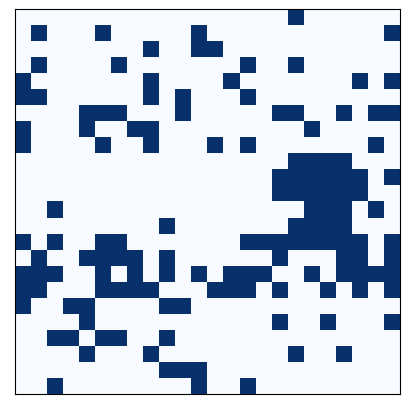

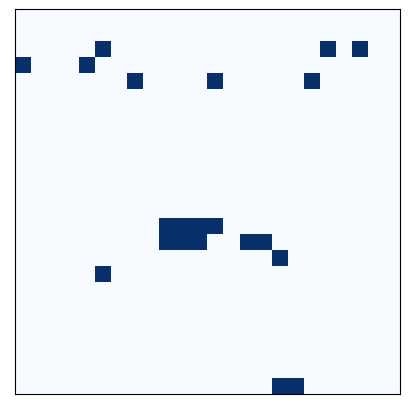

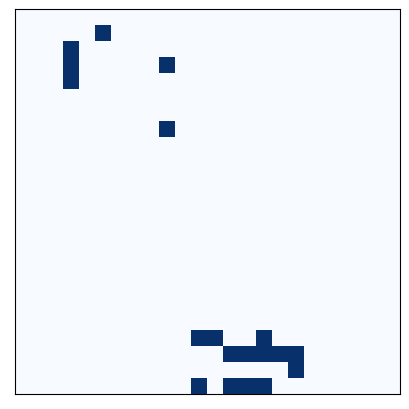

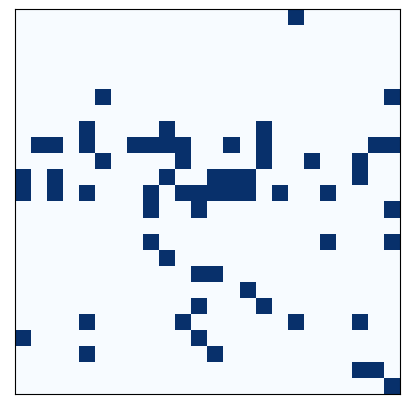

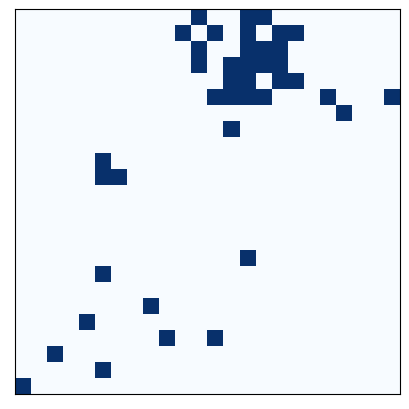

In [14]:
for mask in model.kvto_mask[0]:
    plot_attentin_map_in_nxn_grid(mask.cpu().detach().flatten())